### Import Packages

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime
import os
from zipfile import ZipFile
import random
import networkx as nx
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Read file and data preprocess

#### Read scooter data in GNV: Veo Ride

In [2]:
GNV_scooter_data = pd.read_csv('GNV_scooter_data.csv')
GNV_scooter_data = GNV_scooter_data.dropna()
GNV_scooter_data = GNV_scooter_data.drop(columns = {'Rides Ride ID', 'Rides Vehicle Type'})
GNV_scooter_data = GNV_scooter_data.rename(columns = {'Rides Ride Started At Local Date': 'Start_date',
                                                      'Rides Ride Started At Local Time': 'Start_time',
                                                      'Rides Ride Ended At Local Time': 'End_time',
                                                      'Rides Lng Pickup': 'Start_lng',
                                                      'Rides Lat Pickup': 'Start_lat',
                                                      'Rides Lng Dropoff': 'End_lng',
                                                      'Rides Lat Dropoff': 'End_lat'})
GNV_scooter_data['Start_coordinate'] = GNV_scooter_data[['Start_lng', 'Start_lat']].values.tolist()
GNV_scooter_data['Start_coordinate'] = GNV_scooter_data['Start_coordinate'].apply(Point)
GNV_scooter_data['End_coordinate'] = GNV_scooter_data[['End_lng', 'End_lat']].values.tolist()
GNV_scooter_data['End_coordinate'] = GNV_scooter_data['End_coordinate'].apply(Point)
GNV_scooter_data['Start_date'] = pd.to_datetime(GNV_scooter_data['Start_date'])
GNV_scooter_data['Start_time'] = pd.to_datetime(GNV_scooter_data['Start_time'])
GNV_scooter_data['End_time'] = pd.to_datetime(GNV_scooter_data['End_time'])
print(len(GNV_scooter_data))
GNV_scooter_data.head()

170029


,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444)
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678)
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269)
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047)
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333)


#### Select scooter data within GNV

In [3]:
fl_city_boundary = gpd.read_file('Map/fl_city_boundary.shp')
Gainesville_boundary = fl_city_boundary.loc[fl_city_boundary['NAME'] == 'GAINESVILLE'].reset_index(drop=True)
Gainesville_boundary['geometry'] = Gainesville_boundary['geometry'].to_crs('epsg:4326')

# GNV_scooter_data = gpd.GeoDataFrame(GNV_scooter_data)

index_within_gnv = []
for ii in range (len(GNV_scooter_data)):
    if (Gainesville_boundary['geometry'].contains(GNV_scooter_data.Start_coordinate.iloc[ii])[0] and Gainesville_boundary['geometry'].contains(GNV_scooter_data.End_coordinate.iloc[ii])[0]):
        index_within_gnv.append(ii)
index_within_gnv = np.array(index_within_gnv)
GNV_scooter_data = GNV_scooter_data.iloc[index_within_gnv]
print(len(GNV_scooter_data))

169147


#### Compute geometric distance

In [4]:
start_geo = gpd.GeoDataFrame({'geometry': GNV_scooter_data['Start_coordinate']}, crs='EPSG:4326').to_crs('EPSG:5234')
end_geo = gpd.GeoDataFrame({'geometry': GNV_scooter_data['End_coordinate']}, crs='EPSG:4326').to_crs('EPSG:5234')
GNV_scooter_data['Geometric Distance in Miles'] = start_geo.distance(end_geo) * 0.00062137
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678


#### Compute trip duration

In [5]:
GNV_scooter_data['Trip Duration in Minutes'] = (GNV_scooter_data['End_time'] - GNV_scooter_data['Start_time']).dt.total_seconds()/60
GNV_scooter_data = GNV_scooter_data.loc[GNV_scooter_data['Trip Duration in Minutes'] >= 0].reset_index(drop=True)
GNV_scooter_data = GNV_scooter_data.loc[GNV_scooter_data['Trip Duration in Minutes'] <= 360].reset_index(drop=True)
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593,5.250000
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760,17.966667
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600,14.550000
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425,5.166667
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678,6.683333


#### Trip duration and distance distribution

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_21272\1656251754.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=GNV_scooter_data['Trip Duration in Minutes'], kde = False, bins=40, norm_hist = True, color='grey',


Text(0, 0.5, 'Probability density')

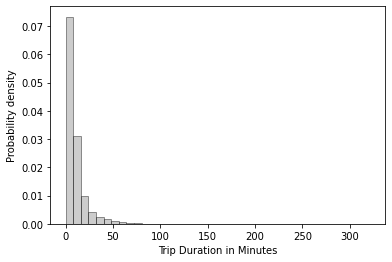

In [6]:
## trip duration distribution
sns.distplot(a=GNV_scooter_data['Trip Duration in Minutes'], kde = False, bins=40, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.xlabel('Trip Duration in Minutes')
plt.ylabel('Probability density')

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_21272\1051621780.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=GNV_scooter_data['Geometric Distance in Miles'], kde = False, bins=40, norm_hist = True, color='grey',


Text(0, 0.5, 'Probability density')

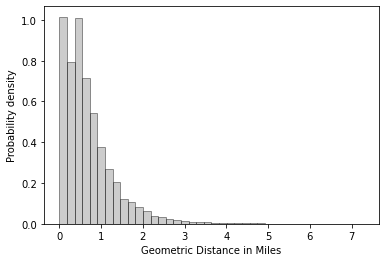

In [7]:
## geometric distance distribution
sns.distplot(a=GNV_scooter_data['Geometric Distance in Miles'], kde = False, bins=40, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.xlabel('Geometric Distance in Miles')
plt.ylabel('Probability density')

#### Add temporal attributes for trips

In [8]:
# add day of a week and hour of a day
# The first recorded data happened in 2021-06-15 (Tuesday)
GNV_scooter_data['Start_year'] = GNV_scooter_data['Start_time'].dt.year
GNV_scooter_data['Start_month'] = GNV_scooter_data['Start_time'].dt.month
GNV_scooter_data['Start_day'] = GNV_scooter_data['Start_time'].dt.day
for i in range (len(GNV_scooter_data)):
    time_delay = (GNV_scooter_data['Start_date'].loc[i] - GNV_scooter_data['Start_date'].iloc[-1]).days + 2
    GNV_scooter_data.at[i, 'Start_day_of_week'] = time_delay - int(time_delay/7)*7
GNV_scooter_data['Start_hour'] = GNV_scooter_data['Start_time'].dt.hour
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes,Start_year,Start_month,Start_day,Start_day_of_week,Start_hour
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593,5.250000,2024,1,5,5.0,1
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760,17.966667,2024,1,5,5.0,6
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600,14.550000,2024,1,5,5.0,11
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425,5.166667,2024,1,5,5.0,9
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678,6.683333,2024,1,5,5.0,9


### Temporal Distribution

#### Monthly variations

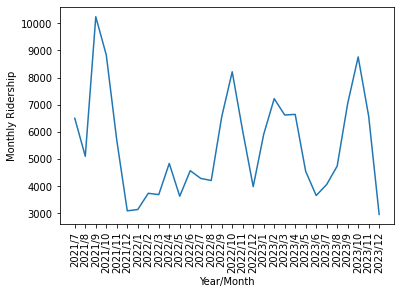

In [9]:
GNV_month_counts = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month']]).value_counts().reset_index()
GNV_month_counts = GNV_month_counts.rename(columns = {0: 'Monthly Ridership'})
GNV_month_counts = GNV_month_counts.sort_values(by=['Start_year', 'Start_month']).reset_index(drop=True)
GNV_month_counts['Year-Month'] = GNV_month_counts['Start_year'].astype(str) + "/" + GNV_month_counts['Start_month'].astype(str)
plt.plot(GNV_month_counts['Year-Month'].iloc[1:-1], GNV_month_counts['Monthly Ridership'].iloc[1:-1])
plt.xlabel('Year/Month')
plt.ylabel('Monthly Ridership')
plt.xticks(rotation = 90)
plt.show()

#### Weekly variations

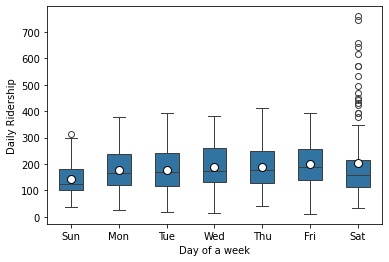

In [10]:
#GNV_start_day_ridership
GNV_week_day_time = GNV_scooter_data.groupby(['Start_year', 'Start_month', 'Start_day'])['Start_day_of_week'].mean().reset_index()
GNV_week_day_ridership = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month', 'Start_day']].value_counts()).reset_index()
GNV_week_day_ridership = GNV_week_day_ridership.rename(columns = {0: 'Daily Ridership'})
GNV_week_day_ridership = GNV_week_day_time.merge(GNV_week_day_ridership, how = 'left', on = ['Start_year', 'Start_month', 'Start_day'])

# Week distribution

# draw boxplot
sns.boxplot(x = 'Start_day_of_week', y = 'Daily Ridership', data = GNV_week_day_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = True,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Day of a week')
plt.ylabel('Daily Ridership')
plt.xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

#### Hourly variations

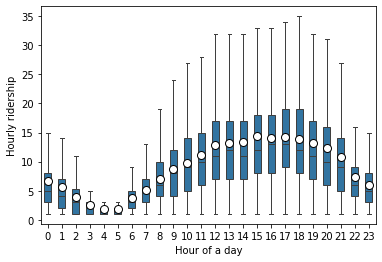

In [11]:
# JAX_start_hour_ridership
GNV_day_hour_ridership = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month', 'Start_day', 'Start_hour']].value_counts()).reset_index()
GNV_day_hour_ridership = GNV_day_hour_ridership.rename(columns = {0: 'Hourly Ridership'})

# Hourly distribution

# draw boxplot without displaying outliers
sns.boxplot(x = 'Start_hour', y = 'Hourly Ridership', data = GNV_day_hour_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = False,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Hour of a day')
plt.ylabel('Hourly ridership')
plt.show()

### Input Spatial Information

#### Census block with geo info

In [12]:
# input census block information (geometry), we need geometry information that we can add into csv files
fl_cenblkgrp = gpd.read_file('Map/cenblkgrp_2020_may23.shp')
fl_GNV_cenblkgrp = fl_cenblkgrp.loc[fl_cenblkgrp['COUNTY'] == 1]
fl_GNV_cenblkgrp['geometry'] = fl_GNV_cenblkgrp['geometry'].to_crs('epsg:4326')
fl_GNV_cenblkgrp = fl_GNV_cenblkgrp.reset_index(drop=True)

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### census attributes in Alachua

In [13]:
# read fl Duval attributes
fl_GNV_tract_att = pd.read_csv('Map/fl_Alachua_tract_attribute.csv')
fl_GNV_tract_att = fl_GNV_tract_att.drop(columns = {'TRACT', 'BLKGRP', 'geometry'})
fl_GNV_tract_att['coordinates'] = fl_GNV_tract_att[['LON', 'LAT']].values.tolist()
fl_GNV_tract_att['coordinates'] = fl_GNV_tract_att['coordinates'].apply(Point)
fl_GNV_tract_att['GEOID'] = fl_GNV_tract_att['GEOID'].astype('str').astype('object')
fl_GNV_tract_att = fl_GNV_tract_att.merge(fl_GNV_cenblkgrp[['GEOID', 'TRACT', 'BLKGRP', 'geometry']], how = 'left', on = 'GEOID')
print(len(fl_GNV_tract_att))

160


#### census attributes in GNV

In [14]:
ct_index_within_gnv = []
for jj in range (len(fl_GNV_tract_att)):
    if Gainesville_boundary['geometry'].contains(fl_GNV_tract_att.geometry.iloc[jj])[0]:
        ct_index_within_gnv.append(jj)
fl_GNV_tract_att = fl_GNV_tract_att.iloc[ct_index_within_gnv]
print(len(fl_GNV_tract_att))

59


#### Show maps of census tracts, scooter trip, and basemap

(-82.43244846431782, -82.21231861289532, 29.58878255923895, 29.78745371130791)

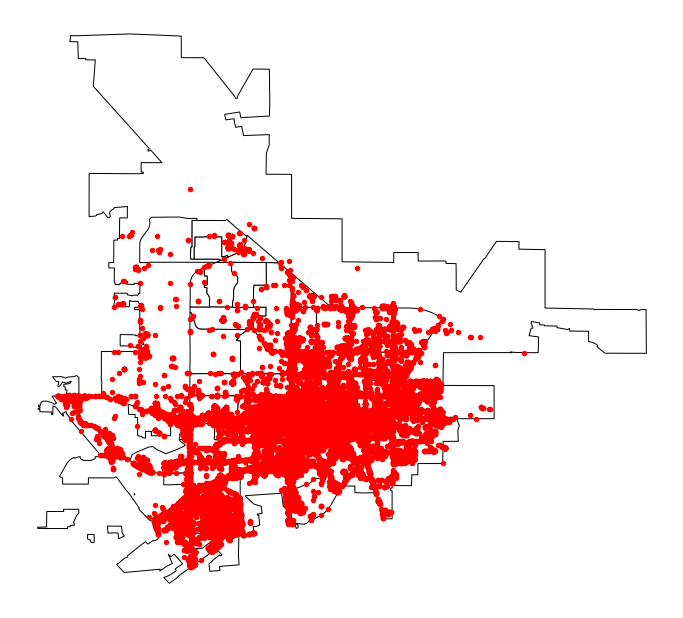

In [15]:
fl_GNV_tract_att = gpd.GeoDataFrame(fl_GNV_tract_att)
GNV_scooter_data = gpd.GeoDataFrame(GNV_scooter_data)
    
# draw a base map of duval boundary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = fl_GNV_tract_att.plot(ax=base1, color = 'white', edgecolor = 'black') # color='#e32636'
GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

#### GNV RTS bus stops and transportation POI

In [16]:
## Bus Stop
gnv_rts_bus_stop = gpd.read_file('Map/RTSBusStops_Spring2025.shp')
gnv_rts_bus_stop.head()

,OBJECTID,OBJECTID_1,BSID,STOP_NAME,DESCRIPTIO,STREET,CROSS_STRE,LATITUDE,LONGITUDE,INTERSECTI,...,NO_BENCHES,NO_TRASHCA,NO_SHELTER,SHELTER_TY,NO_BIKERAC,NIGHTTIME_,LIGHTING_T,ADA_NOTES,NOTES,geometry
0,1,614,1,Rosa Parks Downtown Station,Northbound SE 3rd ST @ Nearside SE 3rd ST,SE 3rd ST,SE 3rd ST,29.645567,-82.322697,Midblock,...,34,13,6,Metal,10,1,Shelter,None,None,POINT (-82.32270 29.64557)
1,2,1318,2,Hampton Inn Hotel,Westbound SE 2nd AVE @ Nearside SE 1st ST,SE 2nd AVE,SE 1st ST,29.650346,-82.323804,Intersection,...,0,1,0,None,2,1,Street,None,None,POINT (-82.32380 29.65035)
2,3,505,3,SW 2nd Avenue @ SW 2nd Street,Westbound SW 2nd AVE @ Nearside SW 2nd ST,SW 2nd AVE,SW 2nd ST,29.650368,-82.326465,Intersection,...,1,1,0,None,0,1,Solar,Sidewalk is only 7ft deep.,None,POINT (-82.32646 29.65037)
3,4,1136,4,The Continuum,Westbound SW 2nd AVE @ Nearside SW 6th ST,SW 2nd AVE,SW 6th ST,29.650325,-82.329674,Intersection,...,1,1,1,Metal,2,1,Street,Shelter is not ADA compliant.,None,POINT (-82.32967 29.65033)
4,5,1137,6,720 SW 2nd Ave,Westbound SW 2nd AVE @ Nearside SW 8th ST,SW 2nd AVE,SW 8th ST,29.650335,-82.332790,Intersection,...,0,0,0,None,0,1,Street,None,None,POINT (-82.33279 29.65033)


In [17]:
## Transportation POI
alachua_poi = gpd.read_file('Map/alachua_county_poi.geojson')
# residential_poi_list = ['grave_yard', 'shelter', 'refuge', 'townhall']
# education_poi_list = ['school', 'kindergarten', 'conference_centre', 'research_institute', 'university', 'college', 'dancing_school', 'music_school', 'tutor', 'prep_school', 'language_school']
# cultural_poi_list = ['hospital (historic)', 'bell', 'arts_centre', 'library', 'planetarium', 'theatre', 'theatre (historic)', 'archive', 'gallery', 'public_bookcase']
# recreational_poi_list = ['bar', 'biergarten', 'alcohol', 'karaoke_box', 'music_venue', 'fountain', 'bench', 'social_club', 'cinema', 'studio', 'pub', 'dojo', 'nightclub', 'stripclub']
# social_poi_list = ['community_centre', 'animal_shelter', 'give_box', 'chair', 'lounger', 'trailer_park', 'smoking_area', 'telephone', 'library_dropoff', 'social_centre', 'recycling', 'nursing_home', 'social_facility', 'childcare', 'drinking_water', 'toilets', 'waste_basket']
transportation_poi_list = ['parking_entrance', 'vehicle_inspection', 'parking_space', 'ranger_station',  'boat_rental', 'motorcycle_parking', 'charging_station', 'bicycle_repair_station', 'ferry_terminal', 'bicycle_rental', 'car_rental', 'bicycle_parking', 'parking', 'post_box', 'car_sharing', 'fuel', 'taxi', 'bus_station']
# commercial_poi_list = ['bank', 'cloakroom', 'restaurant', 'spa', 'parcel_locker', 'internet_cafe',  'bbq', 'fast_food', 'cafe', 'car_wash', 'loading_dock', 'marketplace',  'animal_boarding', 'events_venue', 'dry_cleaner', 'nail_salon', 'check_cashing', 'catering', 'ice_cream', 'money_transfer', 'money_transfer;notary_public', 'vending_machine', 'atm', 'coworking_space', 'food_court', 'office']
# government_poi_list = ['post_office', 'courthouse', 'government']
# religion_poi_list = ['place_of_worship', 'crypt', 'place_of_meditation']
# health_poi_list = ['hospital', 'doctors', 'clinic', 'pharmacy', 'veterinary', 'dentist', 'first_aid', 'personal_trainer']
# publicsafety_poi_list = ['fire_station', 'police', 'border_control']

print(len(alachua_poi))

## only keep transportation poi in gnv
gnv_poi = alachua_poi[Gainesville_boundary.geometry.loc[0].contains(alachua_poi.geometry)].reset_index(drop = True)
print(len(gnv_poi))
gnv_trans_poi = gnv_poi[gnv_poi.amenity.isin(transportation_poi_list)].reset_index(drop=True)
print(len(gnv_trans_poi))
gnv_trans_poi.head()

3890
2936
1737


,element_type,osmid,amenity,ele,name,geometry
0,node,84910124,parking_entrance,None,None,POINT (-82.32921 29.65110)
1,node,581350983,parking,None,None,POINT (-82.30620 29.62157)
2,node,583406704,bicycle_parking,None,None,POINT (-82.34506 29.64801)
3,node,1636758280,parking_entrance,None,None,POINT (-82.35072 29.64364)
4,node,1638150345,parking_entrance,None,None,POINT (-82.34142 29.64099)


### Divide GNV into small service areas

#### Strategy 1: grid-based division

4404


(-82.43299999663775, -82.21092661929956, 29.58866048736907, 29.789117830924578)

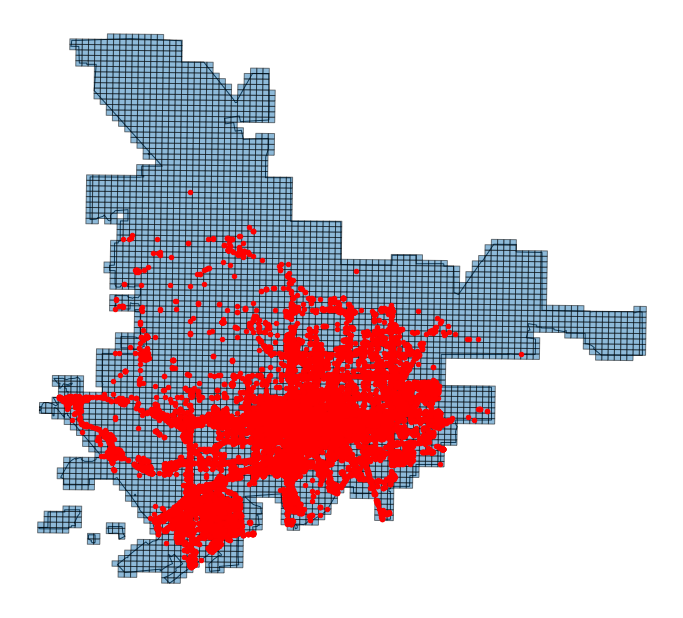

In [18]:
from shapely.geometry import box

def generate_grid(multipolygon, grid_area_threshold):
    bounds = multipolygon.bounds  # Get bounding box (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = bounds

    # Estimate grid size based on area
    # total_area = multipolygon.area
    # piece_area = total_area / num_pieces

    #grid_size = (piece_area ** 0.5)  # Approximate square cell size
    grid_size = (grid_area_threshold ** 0.5)

    # Generate grid cells
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)

    grid_polygons = [
        box(x, y, x + grid_size, y + grid_size)
        for x in x_coords for y in y_coords
    ]

    # Convert to GeoDataFrame and keep only those inside the multipolygon
    grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons)
    grid_gdf = grid_gdf[grid_gdf.intersects(multipolygon)]

    return grid_gdf

Gainesville_boundary_crs = Gainesville_boundary.to_crs(epsg=3087)
multipolygon = Gainesville_boundary_crs.geometry.iloc[0]  # Load MultiPolygon
grid_gdf_crs = generate_grid(multipolygon, grid_area_threshold=40000) # 200*200
grid_gdf = grid_gdf_crs.set_crs(epsg=3087).to_crs(epsg=4326)
print(len(grid_gdf))

# Plot the divided areas
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = grid_gdf.plot(ax=base1, edgecolor='black', alpha=0.5)
GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

(-82.43299999663775, -82.21092661929956, 29.58866048736907, 29.789117830924578)

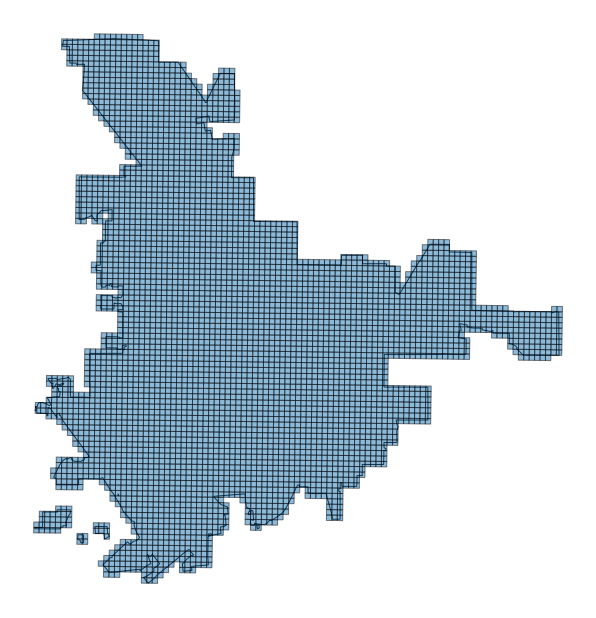

In [19]:
# Plot the divided areas
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = grid_gdf.plot(ax=base1, edgecolor='black', alpha=0.5)
# GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red')
plt.axis("off")

In [20]:
grid_centroid_gdf = grid_gdf.reset_index(drop=True)
grid_centroid_gdf['centroid'] = grid_centroid_gdf['geometry'].centroid
grid_centroid_gdf['latitude'] = grid_centroid_gdf['centroid'].y
grid_centroid_gdf['longitude'] = grid_centroid_gdf['centroid'].x

## days = 934 from 2021-6-15 to 2024-1-5
grid_centroid_gdf['departure_rate'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['arrival_rate'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['dist_transPOI'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['num_transPOI'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['dist_bus_stop'] = np.zeros(len(grid_centroid_gdf))
grid_centroid_gdf['num_bus_stop'] = np.zeros(len(grid_centroid_gdf))

for ii in range (len(grid_centroid_gdf)):
    grid_centroid_gdf['departure_rate'].iloc[ii] = np.sum(grid_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.Start_coordinate))/934
    grid_centroid_gdf['arrival_rate'].iloc[ii] = np.sum(grid_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.End_coordinate))/934


grid_centroid_gdf = gpd.GeoDataFrame(grid_centroid_gdf)
gnv_trans_poi = gpd.GeoDataFrame(gnv_trans_poi)
gnv_rts_bus_stop = gpd.GeoDataFrame(gnv_rts_bus_stop)
GNV_scooter_data = gpd.GeoDataFrame(GNV_scooter_data)
# GNV_scooter_data['Start_coordinate'] = GNV_scooter_data['Start_coordinate'].apply(Point)
# GNV_scooter_data['End_coordinate'] = GNV_scooter_data['End_coordinate'].apply(Point)

# grid_centroid_gdf = grid_centroid_gdf.set_crs('EPSG:4326').to_crs('EPSG:5234')
# GNV_scooter_data = GNV_scooter_data.set_crs('EPSG:4326').to_crs('EPSG:5234')
grid_centroid_gdf['geometry'] = grid_centroid_gdf['geometry'].set_crs('EPSG:4326').to_crs('EPSG:5234')
grid_centroid_gdf['centroid'] = grid_centroid_gdf['centroid'].set_crs('EPSG:4326').to_crs('EPSG:5234')
# GNV_scooter_data['Start_coordinate'] = GNV_scooter_data['Start_coordinate'].set_crs('EPSG:4326').to_crs('EPSG:5234')
# GNV_scooter_data['End_coordinate'] = GNV_scooter_data['End_coordinate'].set_crs('EPSG:4326').to_crs('EPSG:5234')
gnv_trans_poi['geometry'] = gnv_trans_poi['geometry'].to_crs('EPSG:5234')
gnv_rts_bus_stop['geometry'] = gnv_rts_bus_stop['geometry'].to_crs('EPSG:5234')

for ii in range (len(grid_centroid_gdf)):
    dist_transPOI_arr = []
    dist_bus_stop_arr = []
    for jj in range (len(gnv_trans_poi)):
        if grid_centroid_gdf.geometry.iloc[ii].contains(gnv_trans_poi.geometry.iloc[jj]):
            grid_centroid_gdf['num_transPOI'].iloc[ii] += 1
            dist_transPOI_arr.append(grid_centroid_gdf.centroid.iloc[ii].distance(gnv_trans_poi.geometry.iloc[jj]) / 1000)
    grid_centroid_gdf['dist_transPOI'].iloc[ii] = np.mean(np.array(dist_transPOI_arr))
    for kk in range (len(gnv_rts_bus_stop)):
        if grid_centroid_gdf.geometry.iloc[ii].contains(gnv_rts_bus_stop.geometry.iloc[kk]):
            grid_centroid_gdf['num_bus_stop'].iloc[ii] += 1
            dist_bus_stop_arr.append(grid_centroid_gdf.centroid.iloc[ii].distance(gnv_rts_bus_stop.geometry.iloc[kk]) / 1000)
    grid_centroid_gdf['dist_bus_stop'].iloc[ii] = np.mean(np.array(dist_bus_stop_arr))
    
grid_centroid_gdf.dist_transPOI.fillna(1, inplace=True)
grid_centroid_gdf.dist_bus_stop.fillna(1, inplace=True)

grid_centroid_gdf.to_csv('grid_centroid_gdf_new.csv', index = False)
grid_centroid_gdf.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_21272\301918053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroid_gdf['centroid'] = grid_centroid_gdf['geometry'].centroid
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_21272\301918053.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_centroid_gdf['departure_rate'].iloc[ii] = np.sum(grid_centroid_gdf.geometry.iloc[ii].contains(GNV_scooter_data.Start_coordinate))/934
C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_21272\301918053.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

,geometry,centroid,latitude,longitude,departure_rate,arrival_rate,dist_transPOI,num_transPOI,dist_bus_stop,num_bus_stop
0,"POLYGON ((-1439634.006 16028741.911, -1439606....",POINT (-1439517.565 16028653.690),29.615410,-82.421858,0.0,0.0,1.000000,0.0,0.082912,1.0
1,"POLYGON ((-1439606.172 16028537.528, -1439578....",POINT (-1439489.730 16028449.308),29.617211,-82.421832,0.0,0.0,1.000000,0.0,0.114324,2.0
2,"POLYGON ((-1439021.273 16024245.540, -1438993....",POINT (-1438904.821 16024157.340),29.655037,-82.421276,0.0,0.0,0.055772,1.0,1.000000,0.0
3,"POLYGON ((-1438993.402 16024041.163, -1438965....",POINT (-1438876.949 16023952.963),29.656838,-82.421249,0.0,0.0,1.000000,0.0,0.109459,1.0
4,"POLYGON ((-1439839.056 16028713.969, -1439811....",POINT (-1439722.614 16028625.748),29.615387,-82.419790,0.0,0.0,1.000000,0.0,1.000000,0.0


In [21]:
grid_centroid_gdf.departure_rate.describe()

count    4404.000000
mean        0.041120
std         0.276331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002141
max         6.073876
Name: departure_rate, dtype: float64

In [22]:
gnv_trans_poi.head()

,element_type,osmid,amenity,ele,name,geometry
0,node,84910124,parking_entrance,None,None,POINT (-1448079.553 16023238.412)
1,node,581350983,parking,None,None,POINT (-1450860.158 16026240.635)
2,node,583406704,bicycle_parking,None,None,POINT (-1446564.072 16023823.177)
3,node,1636758280,parking_entrance,None,None,POINT (-1446078.065 16024402.488)
4,node,1638150345,parking_entrance,None,None,POINT (-1447043.818 16024564.378)


In [23]:
gnv_rts_bus_stop.head()

,OBJECTID,OBJECTID_1,BSID,STOP_NAME,DESCRIPTIO,STREET,CROSS_STRE,LATITUDE,LONGITUDE,INTERSECTI,...,NO_BENCHES,NO_TRASHCA,NO_SHELTER,SHELTER_TY,NO_BIKERAC,NIGHTTIME_,LIGHTING_T,ADA_NOTES,NOTES,geometry
0,1,614,1,Rosa Parks Downtown Station,Northbound SE 3rd ST @ Nearside SE 3rd ST,SE 3rd ST,SE 3rd ST,29.645567,-82.322697,Midblock,...,34,13,6,Metal,10,1,Shelter,None,None,POINT (-1448731.499 16023128.065)
1,2,1318,2,Hampton Inn Hotel,Westbound SE 2nd AVE @ Nearside SE 1st ST,SE 2nd AVE,SE 1st ST,29.650346,-82.323804,Intersection,...,0,1,0,None,2,1,Street,None,None,POINT (-1448540.487 16022603.143)
2,3,505,3,SW 2nd Avenue @ SW 2nd Street,Westbound SW 2nd AVE @ Nearside SW 2nd ST,SW 2nd AVE,SW 2nd ST,29.650368,-82.326465,Intersection,...,1,1,0,None,0,1,Solar,Sidewalk is only 7ft deep.,None,POINT (-1448276.833 16022640.274)
3,4,1136,4,The Continuum,Westbound SW 2nd AVE @ Nearside SW 6th ST,SW 2nd AVE,SW 6th ST,29.650325,-82.329674,Intersection,...,1,1,1,Metal,2,1,Street,Shelter is not ADA compliant.,None,POINT (-1447959.994 16022692.865)
4,5,1137,6,720 SW 2nd Ave,Westbound SW 2nd AVE @ Nearside SW 8th ST,SW 2nd AVE,SW 8th ST,29.650335,-82.332790,Intersection,...,0,0,0,None,0,1,Street,None,None,POINT (-1447651.497 16022738.119)


In [24]:
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes,Start_year,Start_month,Start_day,Start_day_of_week,Start_hour
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593,5.250000,2024,1,5,5.0,1
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760,17.966667,2024,1,5,5.0,6
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600,14.550000,2024,1,5,5.0,11
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425,5.166667,2024,1,5,5.0,9
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678,6.683333,2024,1,5,5.0,9
